In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time as time
import csv
from scipy.stats.mstats import winsorize
import strat_models
import networkx as nx

# set training and test time

In [2]:
T = 24
train_days = 260 * 7
test_days = 8 * 7
total_days = train_days + test_days + 7

train_hours = train_days * 24
test_hours = test_days * 24
total_hours = total_days * 24

# load data

In [3]:
price_raw_data = []
data_count = 0
with open('data/rt_da_monthly_lmps.csv', newline='') as csvfile:
    datareader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in datareader:
        if 0 < data_count <= total_hours:
            price_raw_data.append(float(row[2]))
        data_count += 1

# preprocessing

In [4]:
# price_data = []
# for i in range(1, 1 + total_hours):
#     price_data.append(float(price_raw_data[i]))

# price_data = np.array(price_data).reshape((total_days, T))
# price_data_flat = price_data.flatten()

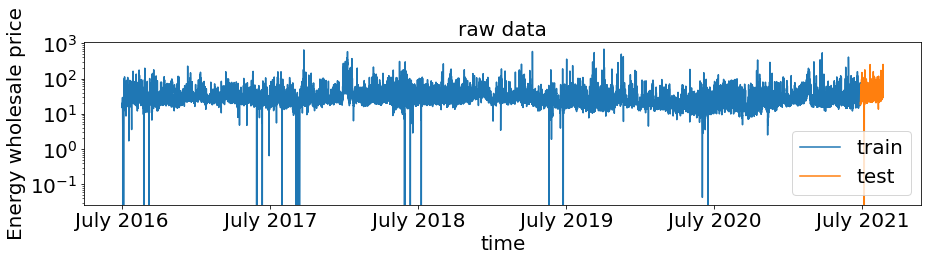

In [5]:
plt.figure(figsize=(15, 3))
plt.plot(np.arange(0, train_hours), price_raw_data[0: train_hours], label="train")
plt.plot(np.arange(train_hours, total_hours - 24 * 7), 
         price_raw_data[train_hours: total_hours - 24 * 7], label="test")

plt.xticks(np.arange(0, total_days * 24, 365 * 24),
          ["July 2016", "July 2017", "July 2018", "July 2019", "July 2020", "July 2021"])

plt.xlabel("time", fontsize=20)
plt.ylabel("Energy wholesale price", fontsize=20)
plt.legend(fontsize=20)
plt.yscale("log")
plt.title("raw data", fontsize=20)
_ = plt.xticks(fontsize=20)
_ = plt.yticks(fontsize=20)

In [6]:
print("==== raw data ====")
print("  mean price", np.mean(price_raw_data))
print("  median price", np.median(price_raw_data))
print("  min and max price", np.min(price_raw_data), np.max(price_raw_data))
price_data = np.array(winsorize(price_raw_data, limits=[0.002, 0.00]))
print("==== after winsorize ====")
print("  mean price", np.mean(price_data))
print("  median price", np.median(price_data))
print("  min and max price", np.min(price_data), np.max(price_data))

==== raw data ====
  mean price 28.49582933072225
  median price 23.900833
  min and max price -56.71 690.0275
==== after winsorize ====
  mean price 28.517273023521863
  median price 23.900833
  min and max price 6.574167 690.0275


In [7]:
price_training_data = price_data[0: train_hours]

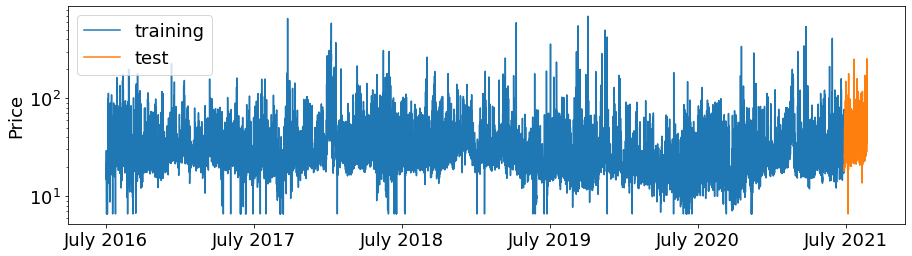

In [8]:
plt.figure(figsize=(15, 4))
plt.plot(np.arange(0, train_hours), price_training_data, label="training")
plt.plot(np.arange(train_hours, train_hours + test_hours), 
         price_data[train_hours: train_hours + test_hours], label="test")

plt.xticks(np.arange(0, total_days * 24, 365 * 24),
          ["July 2016", "July 2017", "July 2018", "July 2019", "July 2020", "July 2021"])

plt.ylabel("Price", fontsize=18)
plt.yscale("log")
plt.legend(fontsize=18)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
# plt.savefig("wholesale_price.pdf")

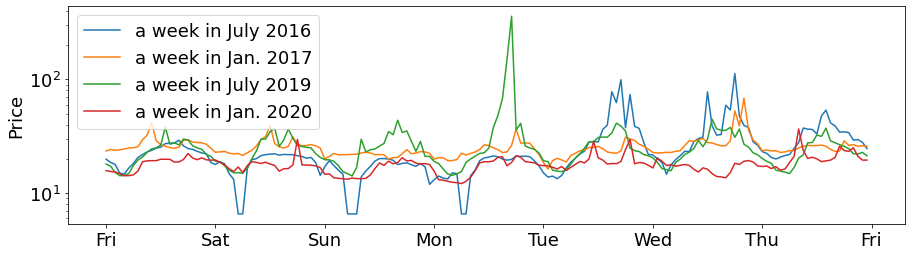

In [9]:
plt.figure(figsize=(15, 4))
plt.plot(price_data[0: 24 * 7 * 1], label="a week in July 2016")
plt.plot(price_data[24 * 7 * 25: 24 * 7 * 26], label="a week in Jan. 2017")
plt.plot(price_data[24 * 7 * 52 * 3: 24 * 7 * (52 * 3 + 1)], label="a week in July 2019")
plt.plot(price_data[24 * 7 * (26 + 52 * 3): 24 * 7 * (26 + 52 * 3 + 1)], 
         label="a week in Jan. 2020")

plt.xticks(np.arange(0, 24 * 7 + 1, 24),
          ["Fri", "Sat", "Sun", "Mon", "Tue", "Wed", "Thu", "Fri"])
plt.ylabel("Price", fontsize=18)
plt.yscale("log")
plt.legend(fontsize=18)
_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)
# plt.savefig("price_data_week.pdf")

In [10]:
log_price_data = np.log(price_data)
loglog_price_data = np.log(log_price_data)
log_price_training_data = np.log(price_training_data)
loglog_price_training_data = np.log(log_price_training_data)

# forecast step 1: baseline

In [11]:
def fit_baseline_model(periods):
    num_periods = len(periods)
    alpha_s = cp.Variable(num_periods)
    beta_s = cp.Variable(num_periods)
    beta_0 = cp.Variable()
    alpha_0 = cp.Variable()
    sin_signals = np.sin(2 * np.pi * np.arange(0, train_hours)[:, None] / periods[None, :])
    cos_signals = np.cos(2 * np.pi * np.arange(0, train_hours)[:, None] / periods[None, :])
    baseline_train = beta_0 + sin_signals @ alpha_s + cos_signals @ beta_s
    baseline_fitting_cost = cp.sum_squares(loglog_price_training_data - baseline_train) / train_hours
    reg = 0.001 * (cp.sum_squares(beta_s) + cp.sum_squares(alpha_s) + cp.square(beta_0))
    baseline_fitting_prob = cp.Problem(cp.Minimize(baseline_fitting_cost + reg))
    baseline_fitting_prob.solve()
    RMS_error = np.sqrt(baseline_fitting_cost.value)
    print("RMS error in loglog domain", RMS_error)
    print("RMS error in log domain", 
          np.sqrt(cp.sum_squares(log_price_training_data - cp.exp(baseline_train)).value / train_hours))
    return beta_0.value, alpha_s.value, beta_s.value, sin_signals, cos_signals

In [12]:
periods = np.array([24 / 4, 24 / 3, 24 / 2, 24, 
                    168 / 4, 168 / 3, 168 / 2, 168, 
                    168 - 24, 168 + 24,
                    365 * 24 / 4, 365 * 24 / 3, 365 * 24 / 2, 365 * 24,
                    365 * 24 - 24, 365 * 24 + 24])
beta0, alphas, betas, sin_signals, cos_signals =  fit_baseline_model(periods)
train_baseline = beta0 + sin_signals.dot(alphas) + cos_signals.dot(betas)

RMS error in loglog domain 0.11180707772945062
RMS error in log domain 0.38199871995224927


In [13]:
def generate_baseline_T(t):
    '''
    generate baseline from t + 1 to t + T
    '''
    sin_T = np.sin(2 * np.pi * np.arange(t + 1, t + T)[:, None] / periods[None, :])
    cos_T = np.cos(2 * np.pi * np.arange(t + 1, t + T)[:, None] / periods[None, :])
    baseline = beta0 + sin_T.dot(alphas) + cos_T.dot(betas)
    return baseline

In [14]:
sin_total = np.sin(2 * np.pi * np.arange(0, total_hours)[:, None] / periods[None, :])
cos_total = np.cos(2 * np.pi * np.arange(0, total_hours)[:, None] / periods[None, :])
total_baseline = beta0 + sin_total.dot(alphas) + cos_total.dot(betas)

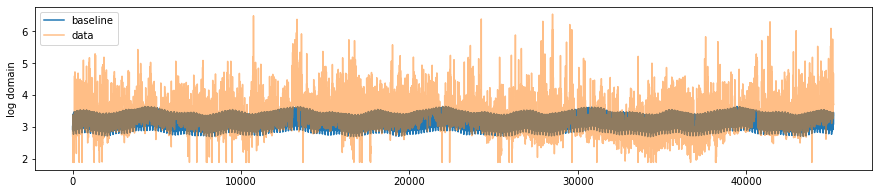

In [15]:
plt.figure(figsize=(15, 3))
plt.plot(np.exp(total_baseline), label="baseline")
plt.plot(log_price_data, alpha=0.5, label="data")
plt.ylabel("log domain")
plt.legend()

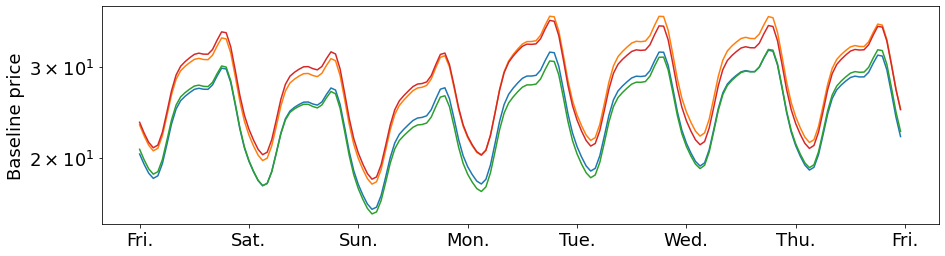

In [16]:
plt.figure(figsize=(15, 4))
plt.plot(np.exp(np.exp(total_baseline[0: 24 * 7 * 1])), label="a week in July 2016")
plt.plot(np.exp(np.exp(total_baseline[24 * 7 * 25: 24 * 7 * 26])), label="a week in Jan. 2017")
plt.plot(np.exp(np.exp(total_baseline[24 * 7 * 52 * 3: 24 * 7 * (52 * 3 + 1)])), label="a week in July 2019")
plt.plot(np.exp(np.exp(total_baseline[24 * 7 * (26 + 52 * 3): 24 * 7 * (26 + 52 * 3 + 1)])), 
         label="a week in Jan. 2020")

plt.xticks(np.arange(0, 24 * 7 + 1, 24),
          ["Fri.", "Sat.", "Sun.", "Mon.", "Tue.", "Wed.", "Thu.", "Fri."])
plt.ylabel("Baseline price", fontsize=18)
plt.yscale("log")
plt.yticks([20, 30], [r"$2 \times 10^1$", r"$3 \times 10^1$"])

_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

In [17]:
training_residual = loglog_price_training_data - total_baseline[0: train_hours]

# forecast step 2: auto-regressive residual

In [18]:
def fit_AR_model(M, ep=1e3):
    prev = []
    post = []
    for t in range(M - 1, train_hours - T):
        prev.append(training_residual[t - M + 1: t + 1])
        post.append(training_residual[t + 1: t + T])
    prev = np.array(prev).T
    post = np.array(post).T
    mtx_inv = np.linalg.inv(prev.dot(prev.T) + ep * np.eye(M))
    gamma = (post.dot(prev.T)).dot(mtx_inv)
    print("RMS error in log log domain", 
          np.linalg.norm(post - gamma.dot(prev)) / np.sqrt(train_hours - T - M + 1) / np.sqrt(T - 1))
    return gamma

RMS error in log log domain 0.08702580506647573


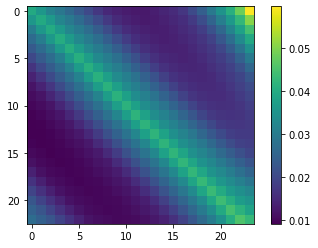

In [19]:
M = 24
gamma = fit_AR_model(M, ep=4e3)
plt.imshow(gamma)
plt.colorbar()

In [20]:
total_residual = loglog_price_data - total_baseline

In [21]:
def generate_AR_residual(t):
    forecast_residual = gamma.dot(total_residual[t - M + 1: t + 1])
    return forecast_residual

In [22]:
def generate_forecast_signal(t):
    forecast_baseline = generate_baseline_T(t)
    forecast_residual = generate_AR_residual(t)
    forecast_signal = forecast_baseline + forecast_residual
    return forecast_signal

# forecast error on training data

In [23]:
forecast_error = []
log_domain_forecast_error = []
meansq_error_log_domain = 0
for t in range(24 * 7, train_hours - T):
    forecast_res = generate_AR_residual(t)
    forecast_error.append(training_residual[t + 1: t + T] - forecast_res)
    log_domain_forecast_error.append(log_price_training_data[t + 1: t + T] -
                                     np.exp(total_baseline[t + 1: t + T] + forecast_res))
    meansq_error_log_domain += np.mean(np.square(log_price_training_data[t + 1: t + T] 
                                                 - np.exp(total_baseline[t + 1: t + T] + forecast_res)))

print("RMS error log domain =", np.sqrt(meansq_error_log_domain / (train_hours - T - 24 * 7)))

RMS error log domain = 0.30221725222940576


In [24]:
forecast_error = np.array(forecast_error)
log_domain_forecast_error = np.array(log_domain_forecast_error)
log_domain_forecast_error_mean = np.mean(log_domain_forecast_error, axis=0)
log_domain_forecast_error_cov = np.cov(log_domain_forecast_error.T)

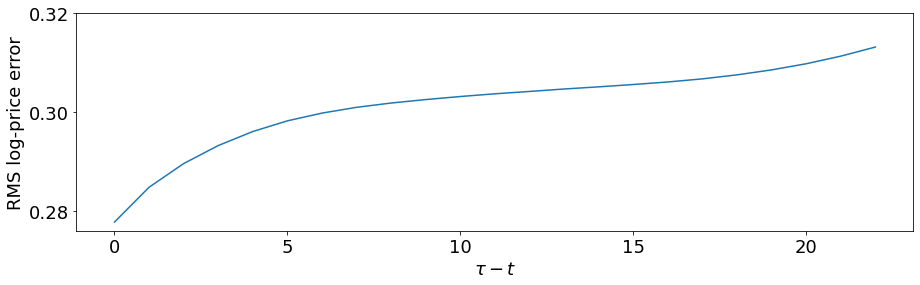

In [25]:
plt.figure(figsize=(15, 4))
plt.plot(np.sqrt(np.diag(log_domain_forecast_error_cov)))
plt.xlabel(r"$\tau - t$", fontsize=18)
plt.ylabel("RMS log-price error", fontsize=18)
_ = plt.xticks(fontsize=18)
_ = plt.yticks([0.28, 0.30, 0.32], ["0.28", "0.30", "0.32"], fontsize=18)

# Laplacian regularized stratified model for forecast error on training data

In [26]:
num_forecast_error, _ = forecast_error.shape
forecast_error_mean = np.mean(forecast_error, axis=0)
forecast_error_cov = np.cov(forecast_error.T)

In [27]:
G = nx.cycle_graph(24 * 7)
strat_models.set_edge_weight(G, 0.001)

In [28]:
Y = []
Z = []
for i in range(24 * 7):
    Y.append(forecast_error[i: num_forecast_error: 24 * 7, :].T - 
             np.mean(forecast_error[i: num_forecast_error: 24 * 7, :], axis=0)[:, None])
    Z.append(i)

In [29]:
data = dict(Y=Y, Z=Z, n=23)

In [30]:
bm = strat_models.BaseModel(loss=strat_models.covariance_max_likelihood_loss(),
                            reg=strat_models.sum_squares_reg(lambd=0.0))

In [31]:
sm = strat_models.StratifiedModel(bm, graph=G)

In [32]:
sm.fit(data, maxiter=500, verbose=True, rho=0.1, min_rho=0.001, mu=5)

 it |     s_norm     r_norm    eps_pri   eps_dual    rho  time1  time2  time3
  1 | 1.9983e+03 1.9982e+02 2.4199e+00 6.2142e-01 0.100 64.531 0.871 123.043
  2 | 2.0596e+02 2.4073e+02 6.6233e-01 6.6234e-01 0.200 49.491 0.116 120.476
  3 | 2.0599e+02 1.9981e+02 6.2759e-01 6.2142e-01 0.200 47.970 0.122 119.382
  4 | 2.0432e+02 1.6017e+02 6.2592e-01 5.8179e-01 0.200 44.413 0.139 115.888
  5 | 1.3538e+02 1.3444e+02 5.5698e-01 5.5607e-01 0.200 42.856 0.124 113.690
  6 | 8.7070e+01 1.1765e+02 5.3924e-01 5.3929e-01 0.200 54.442 0.120 120.766
  7 | 6.1043e+01 1.0563e+02 5.2722e-01 5.2728e-01 0.200 46.211 0.136 110.565
  8 | 4.6855e+01 9.6414e+01 5.1801e-01 5.1807e-01 0.200 46.096 0.124 121.481
  9 | 3.7581e+01 8.9058e+01 5.1065e-01 5.1073e-01 0.200 49.703 0.115 115.059
 10 | 3.0819e+01 8.3007e+01 5.0460e-01 5.0468e-01 0.200 46.864 0.111 121.622
 11 | 2.5860e+01 7.7913e+01 4.9951e-01 4.9960e-01 0.200 48.530 0.124 114.128
 12 | 2.2166e+01 7.3546e+01 4.9514e-01 4.9524e-01 0.200 43.610 0.116 113.87

108 | 1.5661e+00 6.4667e+00 4.2806e-01 4.3171e-01 0.050 51.494 0.132 116.331
109 | 1.5324e+00 6.3926e+00 4.2799e-01 4.3167e-01 0.050 45.562 0.128 121.984
110 | 1.4999e+00 6.3202e+00 4.2792e-01 4.3164e-01 0.050 51.204 0.125 128.412
111 | 1.4682e+00 6.2493e+00 4.2785e-01 4.3160e-01 0.050 53.896 0.131 118.567
112 | 1.4379e+00 6.1798e+00 4.2778e-01 4.3157e-01 0.050 48.808 0.122 120.492
113 | 1.4083e+00 6.1118e+00 4.2771e-01 4.3154e-01 0.050 53.679 0.126 123.403
114 | 1.3797e+00 6.0452e+00 4.2764e-01 4.3151e-01 0.050 49.538 0.121 117.827
115 | 1.3520e+00 5.9799e+00 4.2758e-01 4.3148e-01 0.050 47.134 0.136 110.677
116 | 1.3249e+00 5.9159e+00 4.2751e-01 4.3145e-01 0.050 45.535 0.114 118.909
117 | 1.2990e+00 5.8532e+00 4.2745e-01 4.3142e-01 0.050 53.164 0.127 120.700
118 | 1.2737e+00 5.7917e+00 4.2739e-01 4.3139e-01 0.050 53.184 0.122 135.088
119 | 1.2491e+00 5.7313e+00 4.2733e-01 4.3137e-01 0.050 59.677 0.142 123.747
120 | 1.2251e+00 5.6721e+00 4.2727e-01 4.3134e-01 0.050 51.220 0.131 114.279

216 | 6.5830e-01 1.7316e+00 4.2333e-01 4.3046e-01 0.025 49.387 0.115 113.858
217 | 6.4908e-01 1.7155e+00 4.2331e-01 4.3046e-01 0.025 49.453 0.125 109.172
218 | 6.4000e-01 1.6997e+00 4.2330e-01 4.3046e-01 0.025 47.899 0.132 112.644
219 | 6.3120e-01 1.6840e+00 4.2328e-01 4.3046e-01 0.025 48.383 0.124 107.805
220 | 6.2246e-01 1.6686e+00 4.2327e-01 4.3046e-01 0.025 54.554 0.127 121.070
221 | 6.1362e-01 1.6533e+00 4.2325e-01 4.3046e-01 0.025 51.997 0.121 117.925
222 | 6.0546e-01 1.6383e+00 4.2324e-01 4.3046e-01 0.025 53.593 0.119 118.130
223 | 5.9736e-01 1.6235e+00 4.2322e-01 4.3046e-01 0.025 50.607 0.126 103.365
224 | 5.8951e-01 1.6088e+00 4.2321e-01 4.3046e-01 0.025 47.007 0.131 119.295
225 | 5.8168e-01 1.5944e+00 4.2319e-01 4.3046e-01 0.025 53.173 0.124 115.765
226 | 5.7398e-01 1.5801e+00 4.2318e-01 4.3046e-01 0.025 51.346 0.119 114.046
227 | 5.6643e-01 1.5661e+00 4.2316e-01 4.3046e-01 0.025 49.031 0.125 107.770
228 | 5.5902e-01 1.5522e+00 4.2315e-01 4.3046e-01 0.025 53.380 0.119 121.828

324 | 2.0244e-01 7.4095e-01 4.2234e-01 4.3052e-01 0.025 48.637 0.122 93.226
325 | 2.0067e-01 7.3590e-01 4.2233e-01 4.3052e-01 0.025 47.052 0.120 88.414
326 | 1.9892e-01 7.3089e-01 4.2233e-01 4.3052e-01 0.025 44.191 0.125 90.875
327 | 1.9719e-01 7.2592e-01 4.2232e-01 4.3052e-01 0.025 45.657 0.125 86.069
328 | 1.9548e-01 7.2099e-01 4.2232e-01 4.3052e-01 0.025 48.955 0.121 94.125
329 | 1.9379e-01 7.1611e-01 4.2231e-01 4.3052e-01 0.025 48.442 0.120 88.554
330 | 1.9212e-01 7.1127e-01 4.2231e-01 4.3052e-01 0.025 47.167 0.126 92.601
331 | 1.9046e-01 7.0647e-01 4.2230e-01 4.3052e-01 0.025 50.124 0.122 89.959
332 | 1.8883e-01 7.0171e-01 4.2230e-01 4.3052e-01 0.025 47.977 0.121 89.685
333 | 1.8721e-01 6.9699e-01 4.2229e-01 4.3052e-01 0.025 49.239 0.120 93.105
334 | 1.8562e-01 6.9231e-01 4.2229e-01 4.3052e-01 0.025 47.669 0.126 89.812
335 | 1.8404e-01 6.8768e-01 4.2228e-01 4.3052e-01 0.025 44.755 0.125 88.450
336 | 1.8248e-01 6.8308e-01 4.2228e-01 4.3052e-01 0.025 46.691 0.123 89.802
337 | 1.8094

{'time': 64.949604491, 'iterations': 409, 'optimal': True}

-110.97590422322476


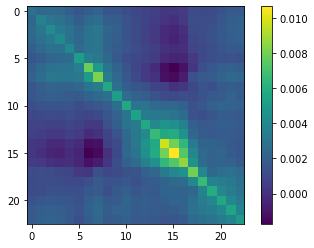

In [33]:
plt.imshow(np.linalg.inv(sm.G.nodes[0]['theta']))
plt.colorbar()
print(sm.anll(data))

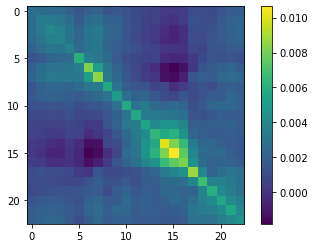

In [34]:
plt.imshow(np.cov(forecast_error[0: num_forecast_error: 24 * 7, :].T))
plt.colorbar()

# plot samples

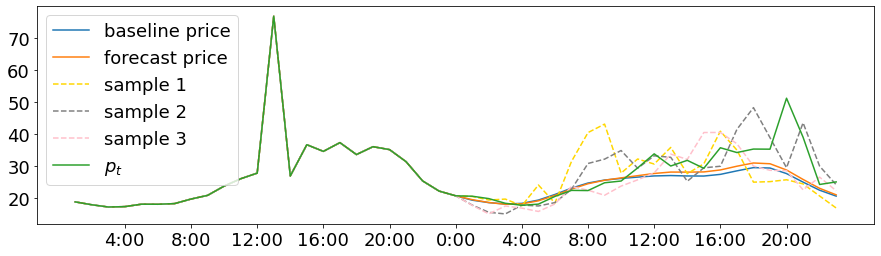

In [35]:
plt.figure(figsize=(15, 4))
t = train_hours
forecast_baseline = generate_baseline_T(t)
forecast_residual = generate_AR_residual(t)
forecast_signal = generate_forecast_signal(t)

plt.plot(np.arange(-23, 24), list(price_data[t - 23: t + 1]) 
         + list(np.exp(np.exp(forecast_baseline))), 
         label="baseline price")

plt.plot(np.arange(-23, 24), list(price_data[t - 23: t + 1])  + 
         list(np.exp(np.exp(forecast_signal))), 
         label="forecast price")
        
forecast_error_samples = forecast_error[t % (24 * 7): num_forecast_error: 24 * 7, :]
forecast_error_mean = np.mean(forecast_error_samples, axis=0)
np.random.seed(10)
forecast_error_normal_samples = np.random.multivariate_normal(forecast_error_mean, 
                                                              np.linalg.inv(sm.G.nodes[t % (24 * 7)]['theta']), 
                                                              size=100)
price_samples = np.exp(np.exp(forecast_signal[None, :] + forecast_error_normal_samples).T)

plt.plot(np.arange(-23, 24), list(price_data[t - 23: t + 1]) + list(price_samples[:, 20]), "--", color="gold",
         label="sample 1")

plt.plot(np.arange(-23, + 24), list(price_data[t - 23: t + 1]) + list(price_samples[:, 21]), "--", color="gray",
         label="sample 2")

plt.plot(np.arange(-23, + 24), list(price_data[t - 23: t + 1]) + list(price_samples[:, 22]), "--", color="pink",
         label="sample 3")

plt.plot(np.arange(- 23, + 24, 1), (price_data[t - 23: t + 24]), label=r"$p_t$")

plt.legend(fontsize=18)

plt.xticks(np.arange(-20, 24, 4), ["4:00", "8:00", "12:00", "16:00", "20:00", "0:00", "4:00", "8:00", "12:00", "16:00", "20:00"])

_ = plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)

# sampling

In [36]:
repeat_times = 10
scenario_samples = np.zeros((repeat_times, 24 * 7, 1000, T - 1))
# scenario_samples_0 = np.load("data/scenario_samples_loglog_strat.npy")
# scenario_samples[0, :, :, :] = scenario_samples_0

In [37]:
np.random.seed(10)
for repeat_idx in range(0, repeat_times):
    for i in range(24 * 7):
        forecast_error_samples = forecast_error[i: num_forecast_error: 24 * 7, :]
        forecast_error_mean = np.mean(forecast_error_samples, axis=0)
        forecast_error_normal_samples = np.random.multivariate_normal(forecast_error_mean, 
                                                                      np.linalg.inv(sm.G.nodes[i]['theta']),
                                                                      size=1000)
        scenario_samples[repeat_idx, i, :, :] = forecast_error_normal_samples

# save forecast and samples

In [38]:
np.save("data/scenario_samples", scenario_samples)

In [39]:
forecast_signals = np.zeros((T - 1, test_hours))
for t in range(train_hours, train_hours + test_hours):
    forecast_signals[:, t - train_hours] = generate_forecast_signal(t)

In [40]:
np.save("data/forecast_signals", forecast_signals)

In [41]:
np.save("data/price_data", price_data)